# MIS S381N Final Project
### Adithya Murali, Andrew White, Carissa Ing, Ramzi Kattan, Siboney Cardoso

## Library Set-Up and Data Loading

In [517]:
%reset -f
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn import tree
from sklearn import metrics
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LassoCV

# Load in Data
rawdata = pd.read_csv('OnlineNewsPopularity.csv')
rawdata = rawdata.drop(['url', ' timedelta'], axis = 1)
shares = ' shares'

# Getting Acquainted with the Data 
rawdata.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


## Exploratory Data Analysis

In [518]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0    n_tokens_title                 39644 non-null  float64
 1    n_tokens_content               39644 non-null  float64
 2    n_unique_tokens                39644 non-null  float64
 3    n_non_stop_words               39644 non-null  float64
 4    n_non_stop_unique_tokens       39644 non-null  float64
 5    num_hrefs                      39644 non-null  float64
 6    num_self_hrefs                 39644 non-null  float64
 7    num_imgs                       39644 non-null  float64
 8    num_videos                     39644 non-null  float64
 9    average_token_length           39644 non-null  float64
 10   num_keywords                   39644 non-null  float64
 11   data_channel_is_lifestyle      39644 non-null  float64
 12   data_channel_is_entertainment  

In [519]:
rawdata.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


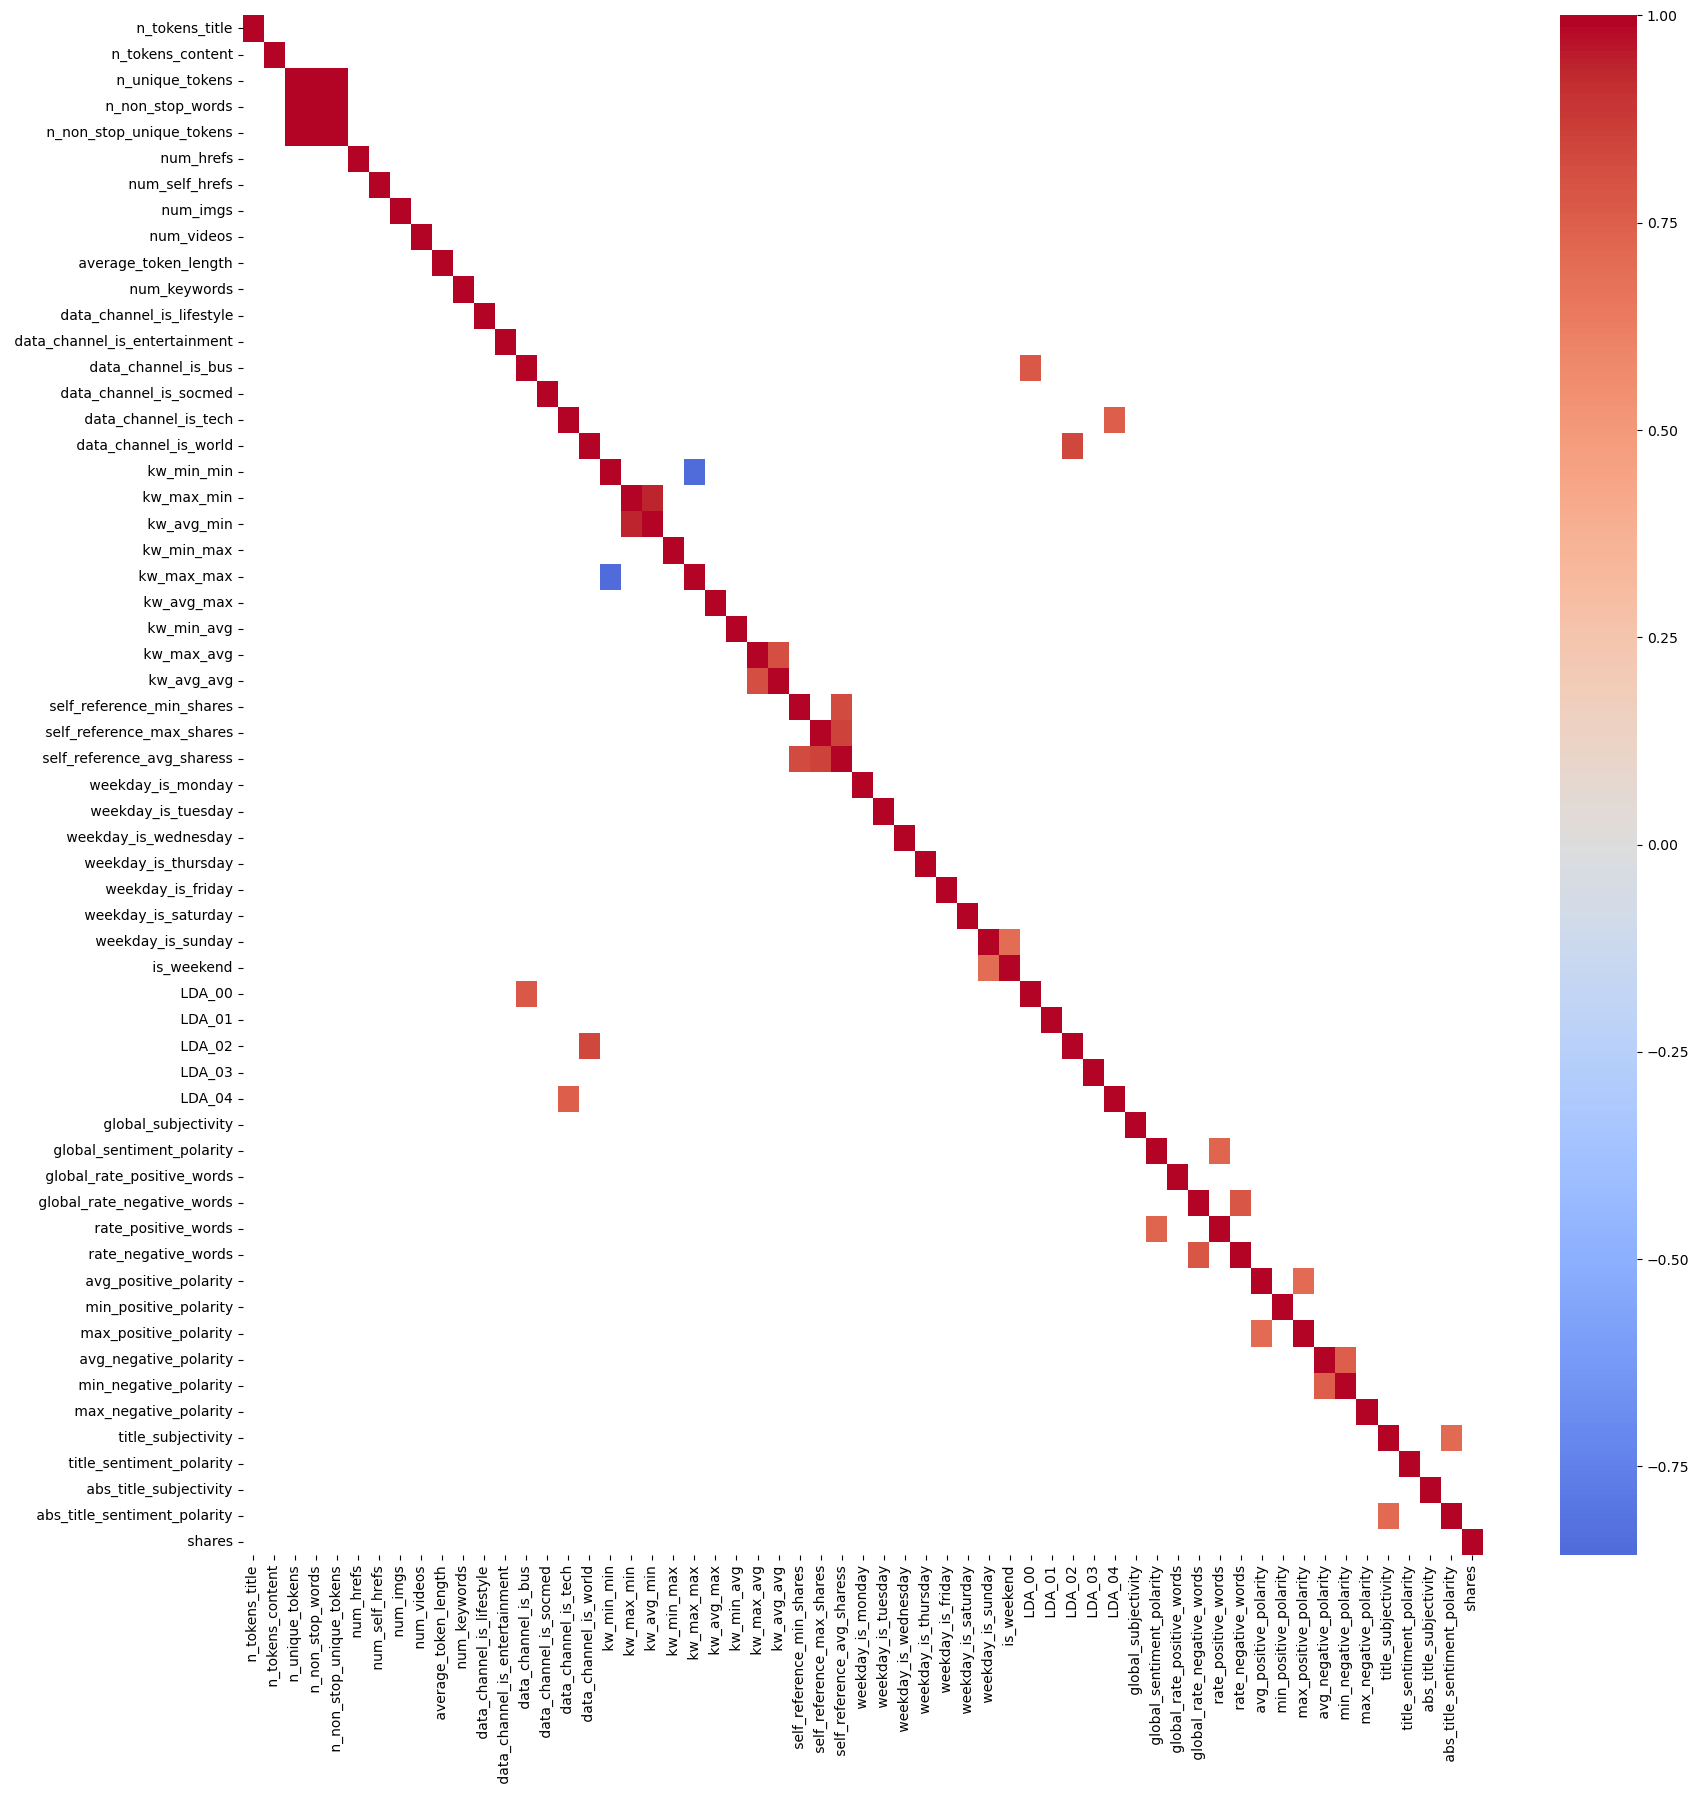

In [520]:
# Dropping Variables with Collinearity 
cor_matrix = rawdata.corr()
threshold = 0.7
strong_corr = cor_matrix[(cor_matrix >= threshold) | (cor_matrix <= -threshold)]

plt.figure(figsize = (20,20))
sns.heatmap(strong_corr, annot=False, cmap='coolwarm', center=0)
plt.show()

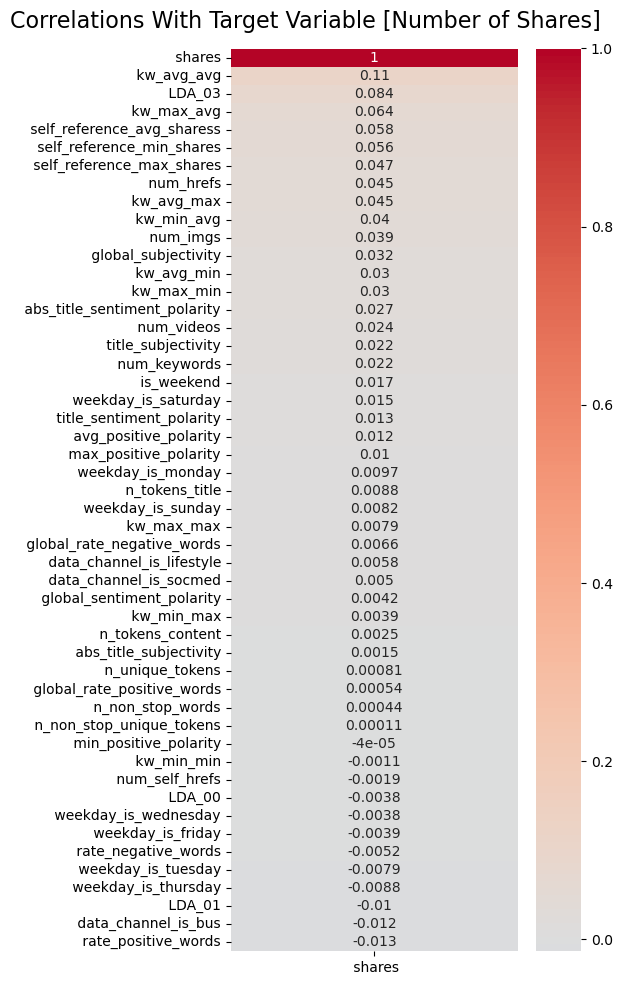

In [521]:
# Creating a Correlation Matrix Heatmap 
correlation_matrix = rawdata.corr()
correlations = correlation_matrix[[shares]].sort_values(by = shares, ascending = False)

fig = plt.figure(figsize = (6, 10))
sns.heatmap(correlations[0:50], annot=True, cmap='coolwarm', center=0)
fig.suptitle('Correlations With Target Variable [Number of Shares]', fontsize=16)
plt.tight_layout()
plt.show()

In [522]:
## Dropping Collinear Variables
rawdata = rawdata.drop([' n_non_stop_words', ' n_non_stop_unique_tokens', ' max_positive_polarity', ' title_sentiment_polarity'], axis = 1)

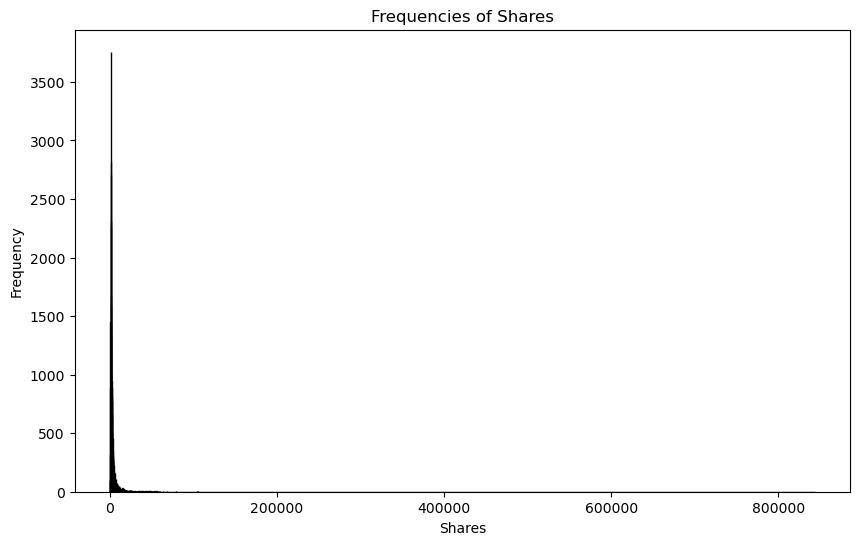

In [523]:
plt.figure(figsize=(10, 6))
plt.hist(rawdata[' shares'], bins='auto', edgecolor='black')
plt.title('Frequencies of Shares')
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.show()

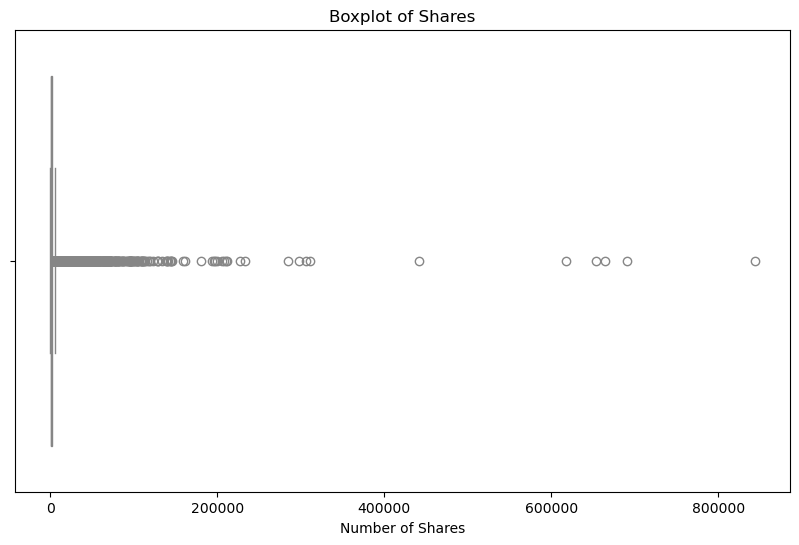

In [524]:
# Box Plots to Detect Outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=rawdata[' shares'], color='pink')
plt.title('Boxplot of Shares')
plt.xlabel('Number of Shares')
plt.show()

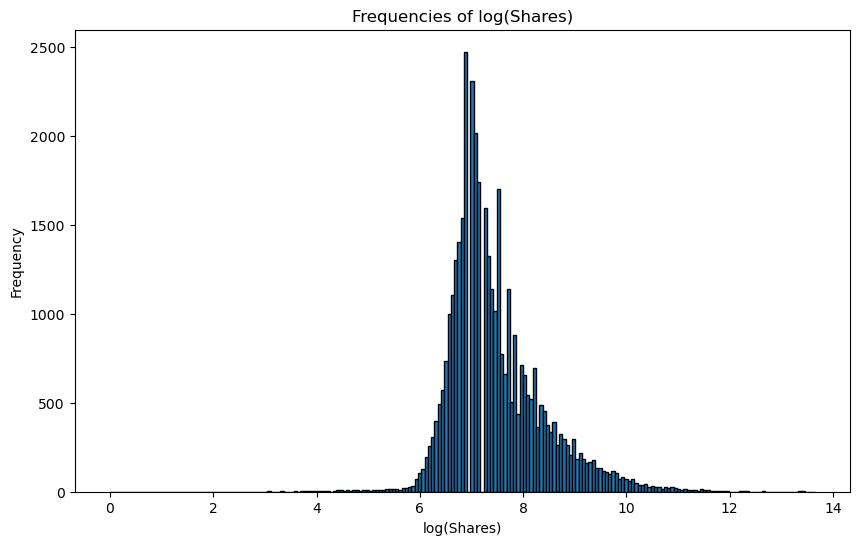

In [525]:
# Taking the Log(Shares) to Regularize Our Distribution
rawdata['logshares'] = rawdata[' shares'].apply(m.log)
plt.figure(figsize=(10, 6))
plt.hist(rawdata['logshares'], bins='auto', edgecolor='black')
plt.title('Frequencies of log(Shares)')
plt.xlabel('log(Shares)')
plt.ylabel('Frequency')
plt.show()

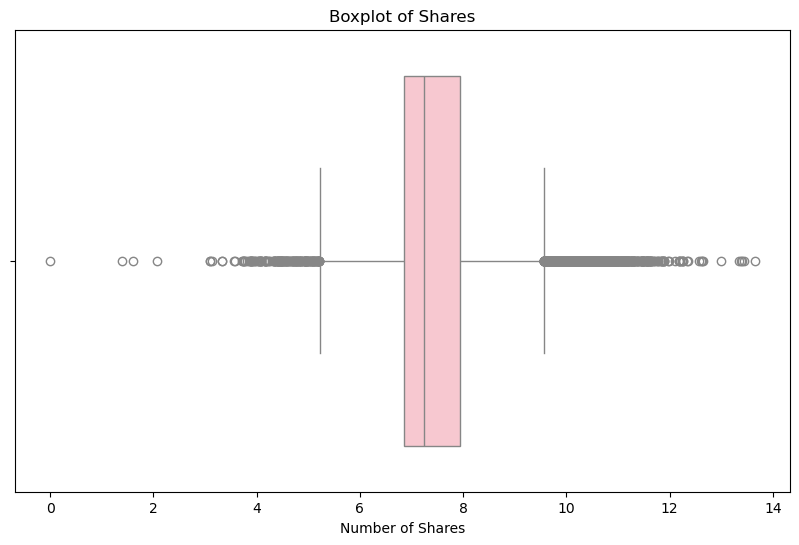

In [526]:
# Comparing to Box Plot of Log(Shares)
plt.figure(figsize=(10, 6))
sns.boxplot(x=rawdata['logshares'], color='pink')
plt.title('Boxplot of Shares')
plt.xlabel('Number of Shares')
plt.show()

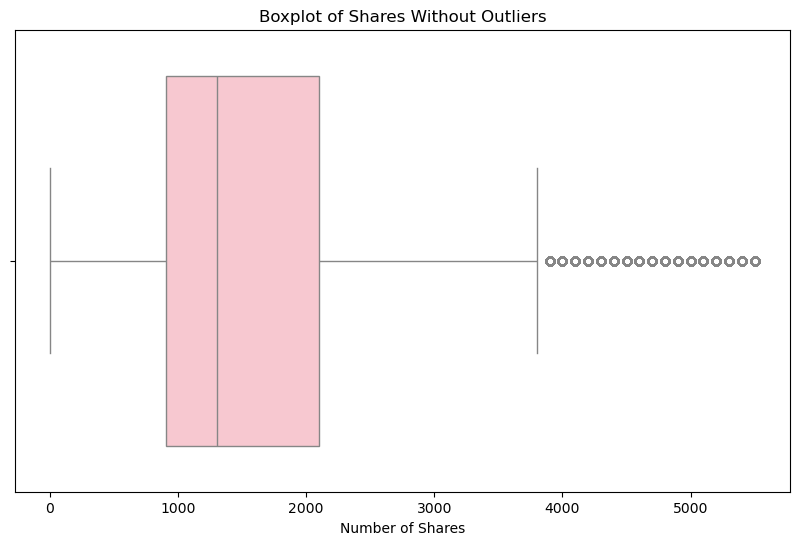

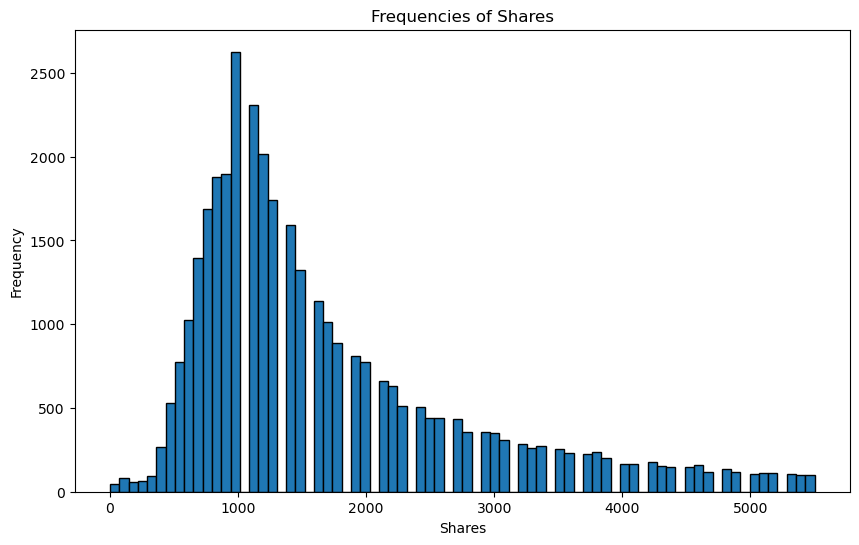

In [527]:
# Effects of Removing Outliers

# Calculate Q1, Q3, and IQR
Q1 = rawdata[' shares'].quantile(0.25)
Q3 = rawdata[' shares'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_no_outliers = rawdata[(rawdata[' shares'] >= lower_bound) & (rawdata[' shares'] <= upper_bound)]

# Plot the boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_no_outliers[' shares'], color='pink')
plt.title('Boxplot of Shares Without Outliers')
plt.xlabel('Number of Shares')
plt.show()

# Plot the Shares After Removing Outliers
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers[' shares'], bins='auto', edgecolor='black')
plt.title('Frequencies of Shares')
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.show()

# Decision -> Remove Outliers

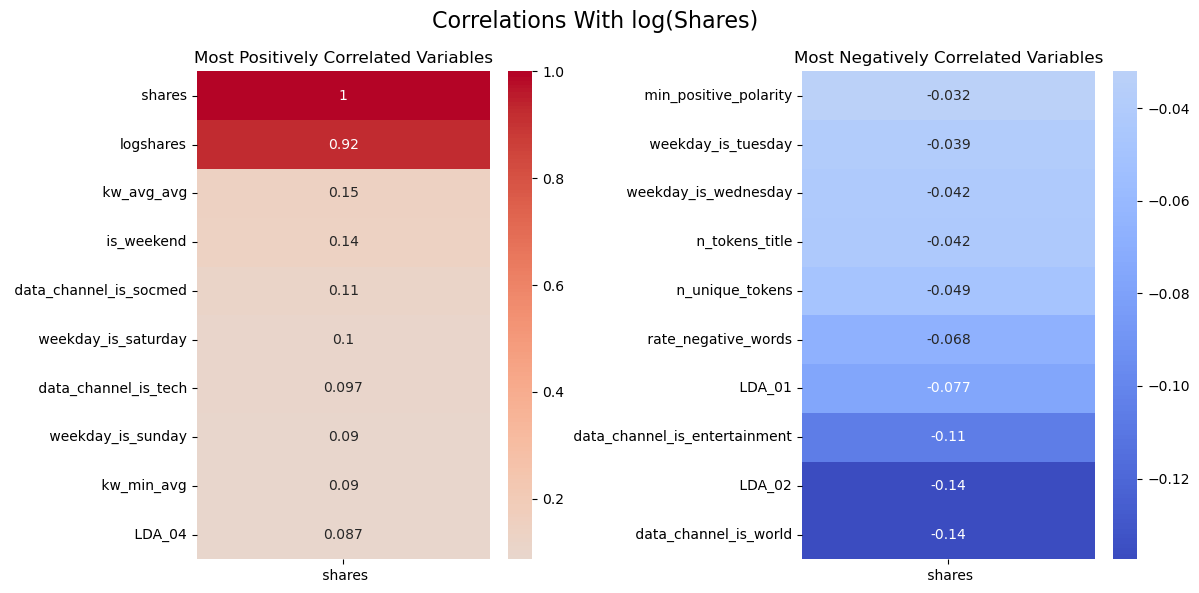

In [528]:
# Creating a Correlation Matrix Heatmap 
correlation_matrix = df_no_outliers.corr()
shares = ' shares'
correlations = correlation_matrix[[shares]].sort_values(by = shares, ascending = False)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(correlations[0:10], annot=True, cmap='coolwarm', center=0, ax = ax[0])
ax[0].set_title('Most Positively Correlated Variables')

sns.heatmap(correlations[-10:], annot=True, cmap='coolwarm', center=0, ax = ax[1])
ax[1].set_title('Most Negatively Correlated Variables')
fig.suptitle('Correlations With log(Shares)', fontsize=16)
plt.tight_layout()
plt.show()

/var/folders/j4/01bw0t0n5195l3682d9brqz40000gn/T/ipykernel_73457/1120450217.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Channel', y=' shares', data=mean_shares_by_channel_melted, palette='viridis')


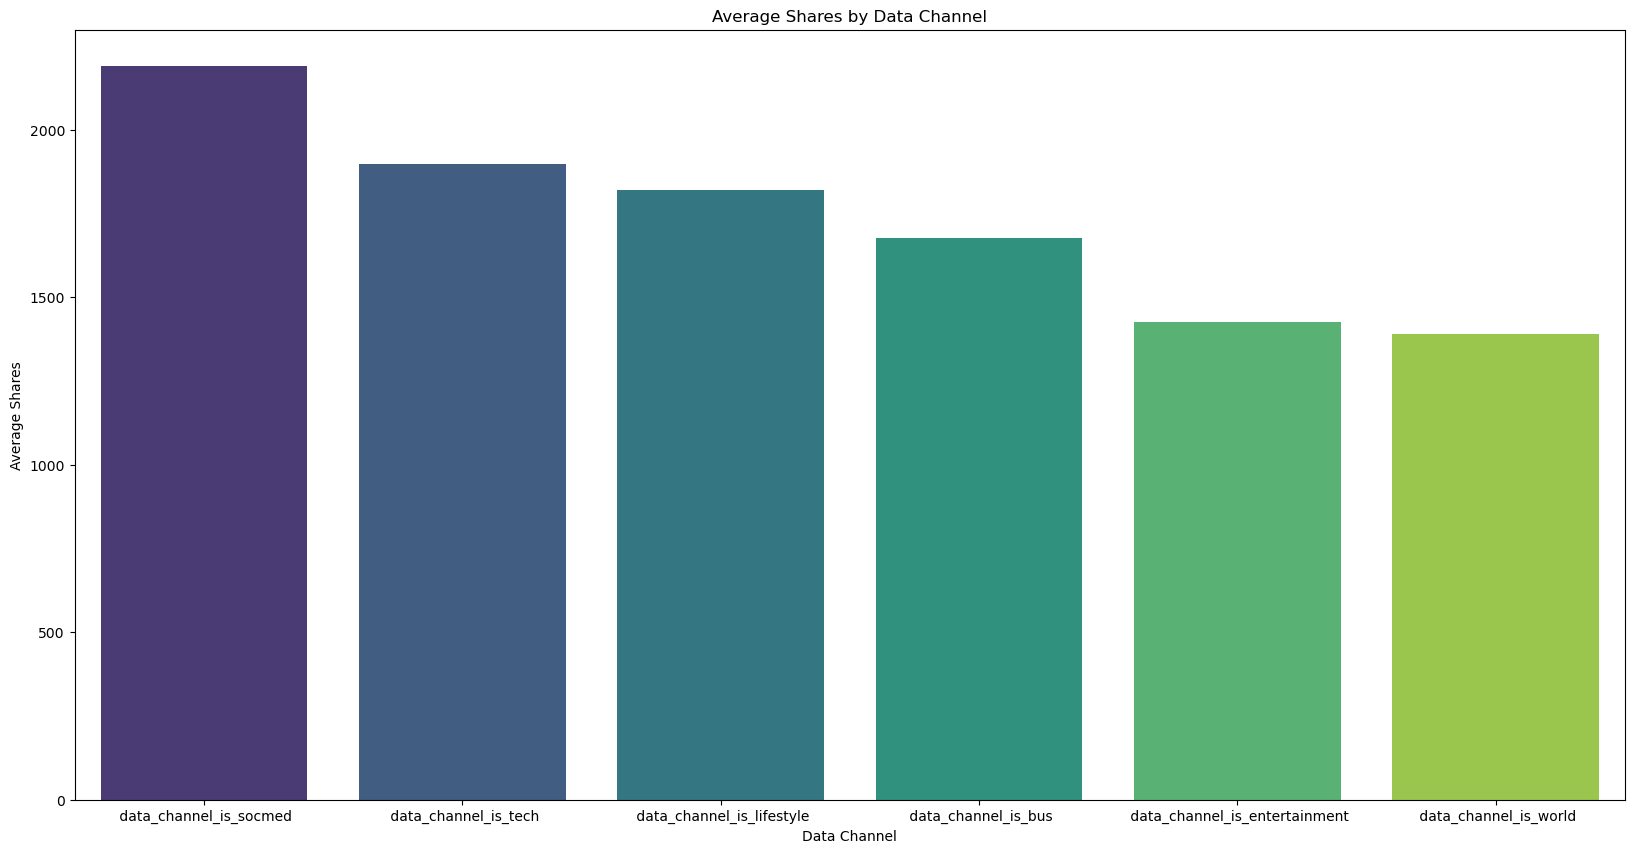

In [529]:
# Data Channel Analysis: Average shares by data channel
data_channels = df_no_outliers[[' data_channel_is_lifestyle', ' data_channel_is_entertainment',
                    ' data_channel_is_bus', ' data_channel_is_socmed',
                    ' data_channel_is_tech', ' data_channel_is_world', ' shares']]

# Calculate the mean shares for each channel
mean_shares_by_channel = data_channels.groupby(data_channels.columns[:-1].tolist()).mean().reset_index()

# Plot the mean shares for each channel
plt.figure(figsize=(20, 10))
mean_shares_by_channel_melted = mean_shares_by_channel.melt(id_vars=' shares', var_name='Channel', value_name='Is_Channel')
mean_shares_by_channel_melted = mean_shares_by_channel_melted[mean_shares_by_channel_melted['Is_Channel'] == 1].sort_values(by = ' shares', ascending = False)
sns.barplot(x='Channel', y=' shares', data=mean_shares_by_channel_melted, palette='viridis')
plt.title('Average Shares by Data Channel')
plt.xlabel('Data Channel')
plt.ylabel('Average Shares')
plt.show()

In [530]:
# Checking Scaling of Predictors
df_no_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
n_tokens_title,35103.0,10.402330,2.108118,2.000000,9.000000,10.000000,12.000000,20.000000
n_tokens_content,35103.0,546.791699,462.714379,0.000000,250.000000,414.000000,715.000000,7764.000000
n_unique_tokens,35103.0,0.531275,0.134254,0.000000,0.471815,0.538721,0.607018,1.000000
num_hrefs,35103.0,10.584423,10.771551,0.000000,4.000000,7.000000,13.000000,187.000000
num_self_hrefs,35103.0,3.297126,3.847926,0.000000,1.000000,3.000000,4.000000,116.000000
num_imgs,35103.0,4.335840,8.091522,0.000000,1.000000,1.000000,3.000000,128.000000
num_videos,35103.0,1.187762,3.962538,0.000000,0.000000,0.000000,1.000000,75.000000
average_token_length,35103.0,4.560363,0.817241,0.000000,4.481877,4.668421,4.858998,8.041534
num_keywords,35103.0,7.199385,1.916833,1.000000,6.000000,7.000000,9.000000,10.000000
data_channel_is_lifestyle,35103.0,0.051221,0.220451,0.000000,0.000000,0.000000,0.000000,1.000000


In [531]:
## Removing the spaces from the variable names
rawdata.columns = rawdata.columns.str.strip()
df_no_outliers.columns = df_no_outliers.columns.str.strip()

In [532]:
# Decisions -> We should z-score our dataset to standarize our variables
scaler = StandardScaler()
scaleddata = pd.DataFrame(scaler.fit_transform(df_no_outliers))
scaleddata.columns = df_no_outliers.columns
mean_values = pd.DataFrame(scaler.mean_).T
mean_values.columns = df_no_outliers.columns
std_values = pd.DataFrame(scaler.scale_).T
std_values.columns = df_no_outliers.columns
scaleddata.describe().T
mean_values
scaleddata.columns = scaleddata.columns.str.strip()

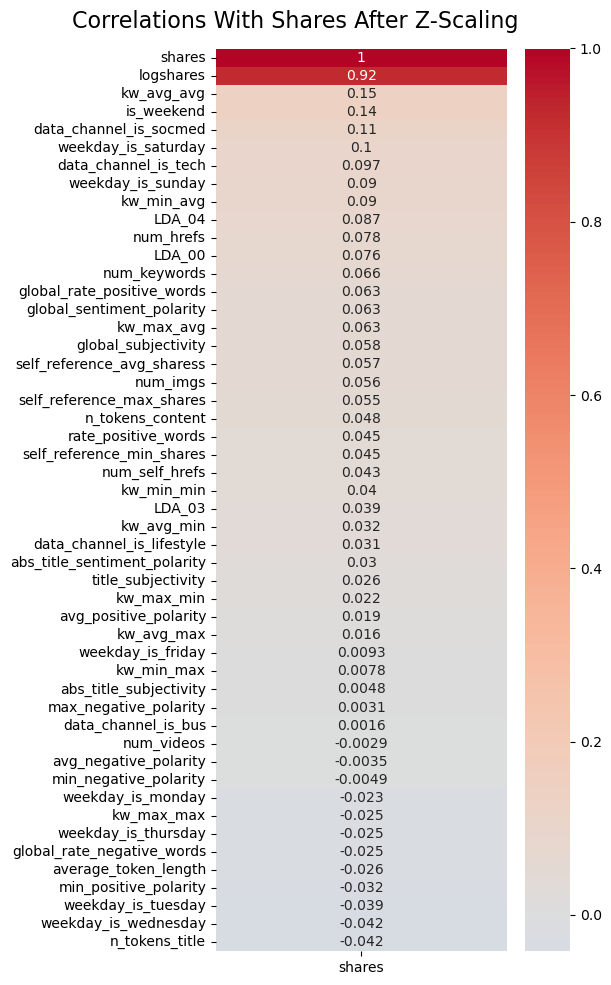

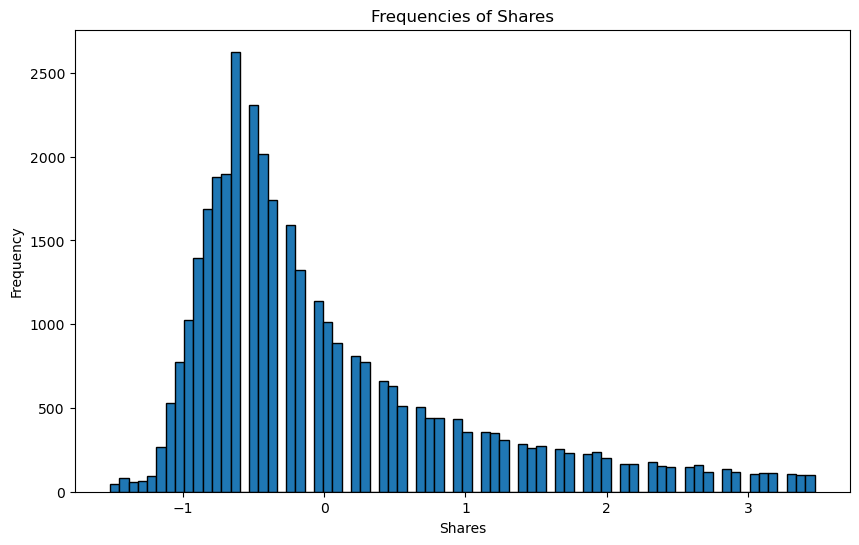

In [533]:
# Creating a Correlation Matrix Heatmap After Z-Scoring
correlation_matrixscaled = scaleddata.corr()
correlationsscaled = correlation_matrixscaled[['shares']].sort_values(by = 'shares', ascending = False)

fig = plt.figure(figsize = (6, 10))
sns.heatmap(correlationsscaled[0:50], annot=True, cmap='coolwarm', center=0)
fig.suptitle('Correlations With Shares After Z-Scaling', fontsize=16)
plt.tight_layout()
plt.show()

# Plot the Shares After Removing Outliers
plt.figure(figsize=(10, 6))
plt.hist(scaleddata['shares'], bins='auto', edgecolor='black')
plt.title('Frequencies of Shares')
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.show()

In [534]:
## Preparing the data for training and testing

# Dropping the shares column so we don't predict with target
scaleddata = scaleddata.drop('logshares', axis = 1) # Running this more than once will give you an error, just comment it out if needed

# Creating the Design Matrices
target = 'shares'
predictors = scaleddata.columns.drop(target).tolist()
formula = f"{target} ~ {' + '.join(predictors)}"
Y, X = dmatrices(formula, scaleddata, return_type = 'dataframe')
shares = Y[target].values

# Creating a Training and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, shares, test_size = 0.2, random_state = 20) # Saving 20% for holdout

## Models

### KNN - Adithya 

Root Mean Squared Error:  1084.20
Normalized Root Mean Squared Error: 19.86%, with a range of  5458.00.
Coefficient of Variation of Root Mean Squared Error: 64.69%, with a mean of  1676.05.


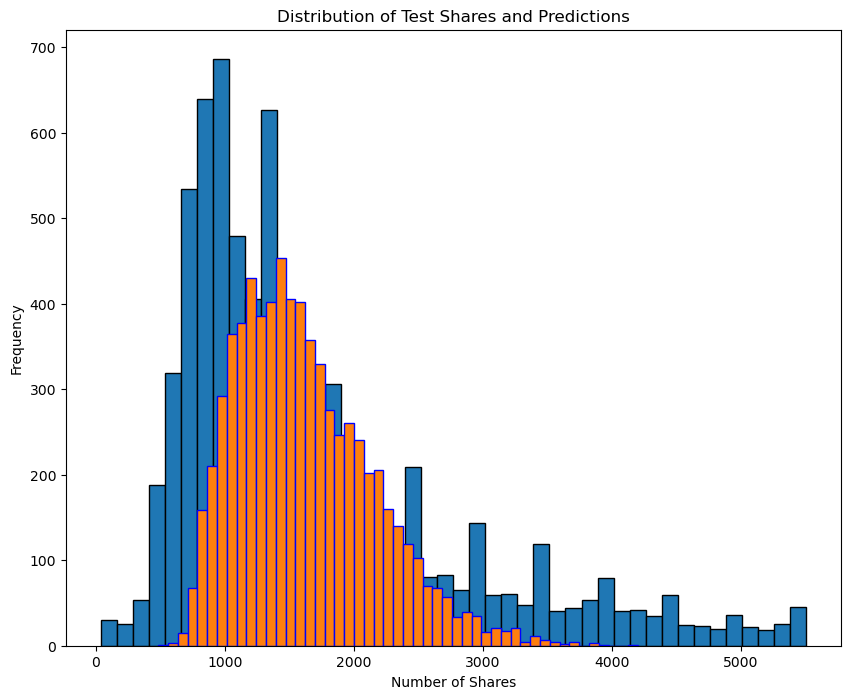

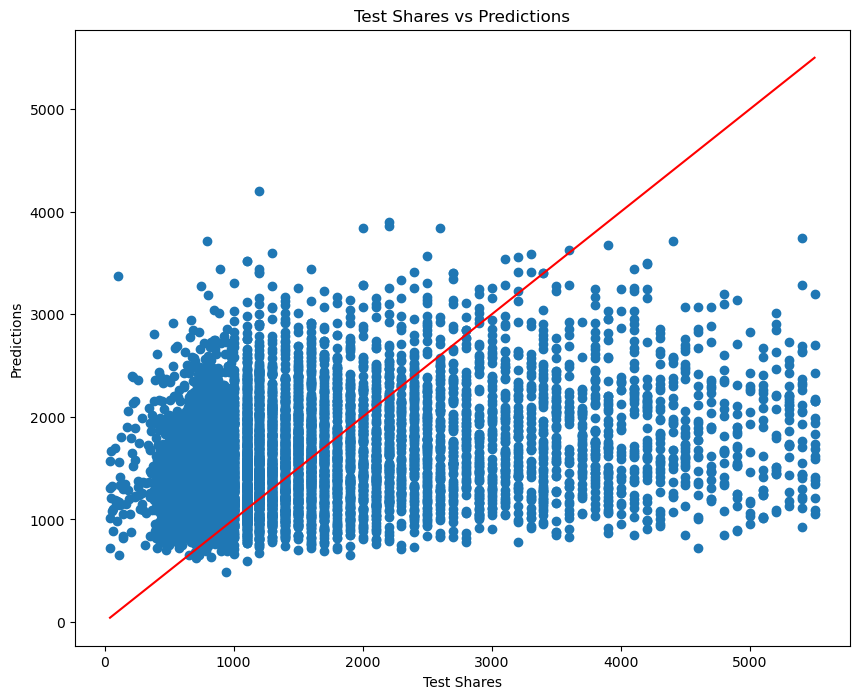

In [535]:
knn_reg = KNeighborsRegressor(n_neighbors=7)
# Train the model
knn_reg.fit(X_train, y_train)
# Make predictions
y_pred = knn_reg.predict(X_test)
# Evaluate the model
mean_sharestrees = mean_values['shares'].values[0]
std_sharestrees = std_values['shares'].values[0]

# Inverse transforming the predictions and true values
ypredknn = y_pred * std_sharestrees + mean_sharestrees
ytesttrees = y_test * std_sharestrees + mean_sharestrees
RMSEknn = np.sqrt(mean_squared_error(ytesttrees, ypredknn))
NRMSEknn = RMSEknn * 100 / (np.max(ytesttrees) - np.min(ytesttrees))
CVRMSEknn = RMSEknn * 100 / np.mean(ytesttrees)

print(f'Root Mean Squared Error: {RMSEknn: .2f}')
print(f"Normalized Root Mean Squared Error: {NRMSEknn:.2f}%, with a range of {np.max(ytesttrees) - np.min(ytesttrees): .2f}.")
print(f"Coefficient of Variation of Root Mean Squared Error: {CVRMSEknn:.2f}%, with a mean of {np.mean(ytesttrees): .2f}.")

plt.figure(figsize = (10,8))
plt.hist(ytesttrees, bins='auto', edgecolor='black')
plt.hist(ypredknn, bins='auto', edgecolor = 'blue')
plt.title("Distribution of Test Shares and Predictions")
plt.xlabel("Number of Shares")
plt.ylabel("Frequency")
plt.show()

min_val = min(min(ytesttrees), min(ypredknn))
max_val = max(max(ytesttrees), max(ypredknn))

plt.figure(figsize = (10, 8))
plt.scatter(ytesttrees, ypredknn)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='red')
plt.title("Test Shares vs Predictions")
plt.xlabel("Test Shares")
plt.ylabel("Predictions")
plt.show()

### Linear Regression - Carissa

Test RMSE: 1044.41
Test NRMSE: 19.14%
Test CVRMSE: 62.31%


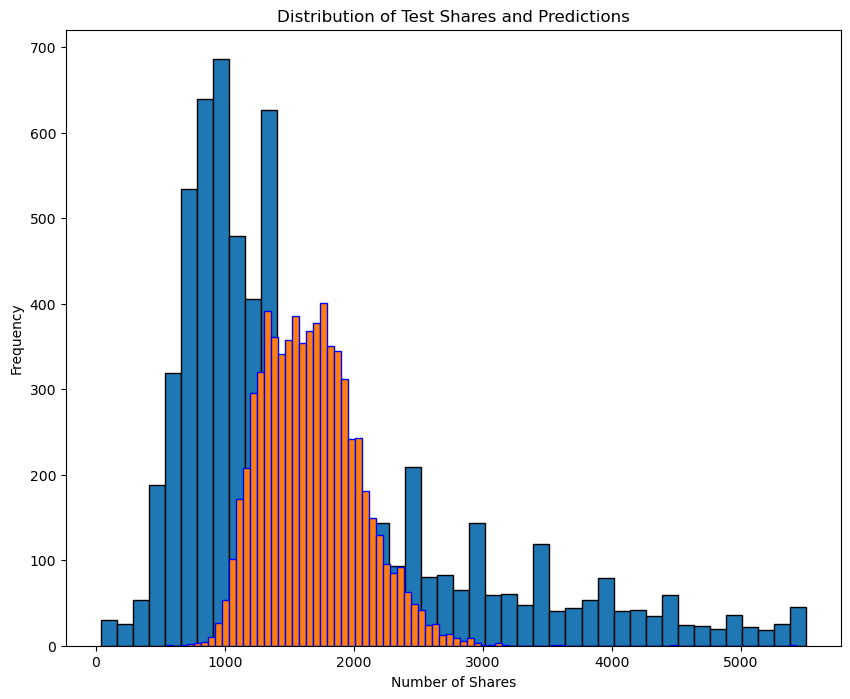

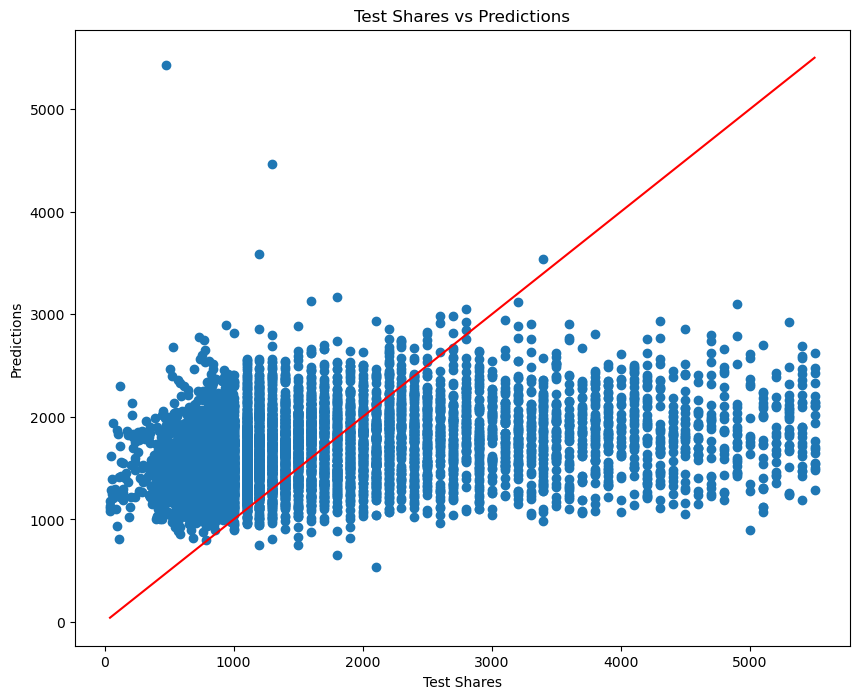

In [536]:
ols = sm.OLS(y_train, X_train)
ols_result = ols.fit()
#print(ols_result.summary())

#Check Test RMSE
mean_shares = mean_values['shares'].values[0]
std_shares = std_values['shares'].values[0]

ols_prediction_test = ols_result.predict(X_test)

ols_predictions = ols_prediction_test * std_shares + mean_shares
ols_y_test = y_test * std_shares + mean_shares

ols_rmse = (metrics.mean_squared_error(ols_y_test, ols_predictions)) ** 0.5
ols_nrmse = ols_rmse * 100 /(max(ols_y_test) - min(ols_y_test))
ols_cvrmse = ols_rmse * 100/np.mean(ols_y_test)
print(f"Test RMSE: {ols_rmse:.2f}")
print(f"Test NRMSE: {ols_nrmse:.2f}%")
print(f"Test CVRMSE: {ols_cvrmse:.2f}%")

#Coeffs by Variable Importance
#print(ols_result.params.sort_values(key=abs, ascending=False))

plt.figure(figsize = (10,8))
plt.hist(ols_y_test, bins='auto', edgecolor='black')
plt.hist(ols_predictions, bins='auto', edgecolor = 'blue')
plt.title("Distribution of Test Shares and Predictions")
plt.xlabel("Number of Shares")
plt.ylabel("Frequency")
plt.show()

min_val = min(min(ols_y_test), min(ols_predictions))
max_val = max(max(ols_y_test), max(ols_predictions))

plt.figure(figsize = (10, 8))
plt.scatter(ols_y_test, ols_predictions)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='red')
plt.title("Test Shares vs Predictions")
plt.xlabel("Test Shares")
plt.ylabel("Predictions")
plt.show()

Best Alpha:  0.0005241394596788624
Test RMSE: 1044.66
Test NRMSE: 19.14%
Test CVRMSE: 62.33%


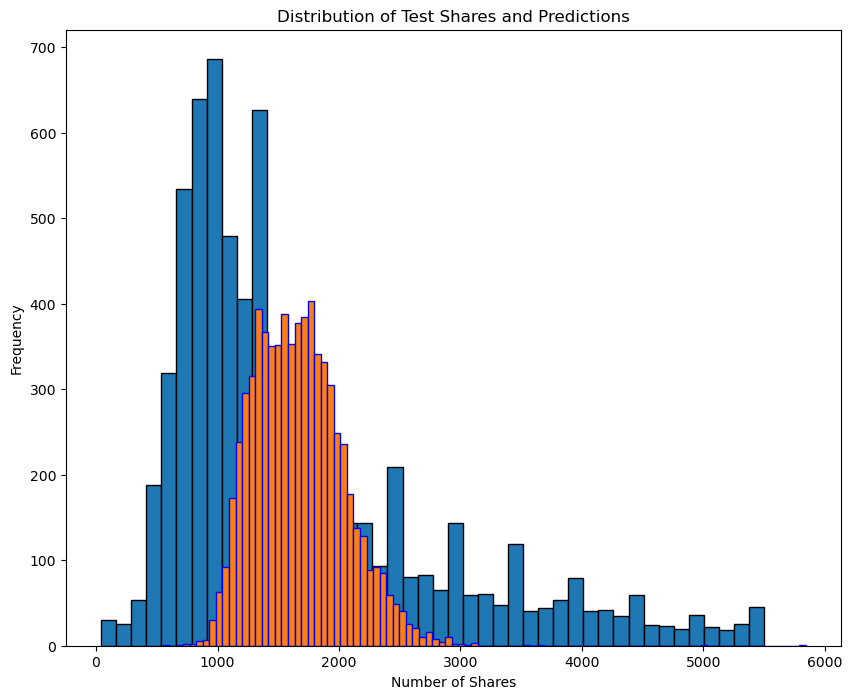

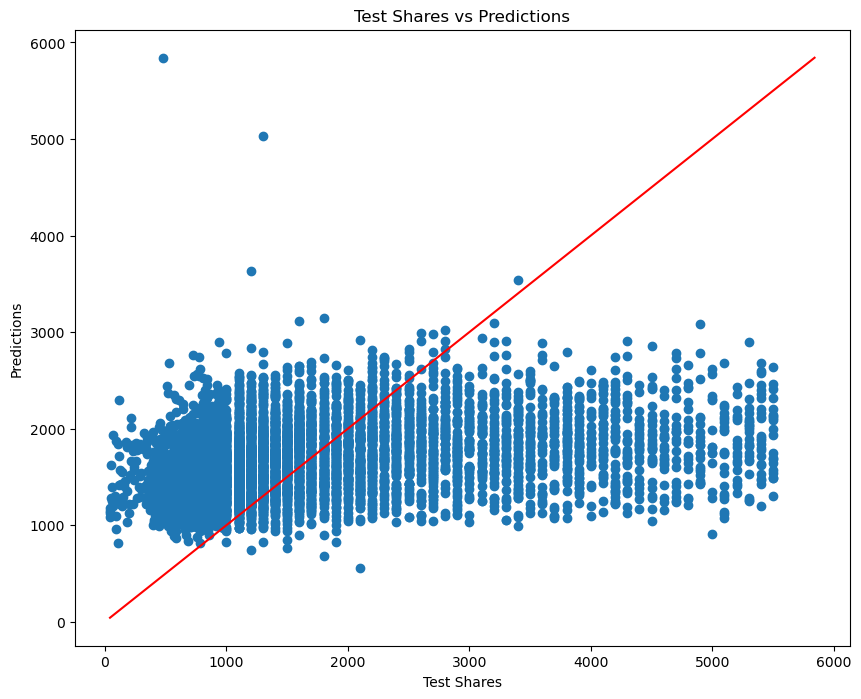

                      Variable  Coefficient
24                  kw_avg_avg     0.364589
36                      LDA_00     0.139965
35                  is_weekend     0.123421
13      data_channel_is_socmed     0.075894
14        data_channel_is_tech     0.074474
45         rate_positive_words     0.058050
40                      LDA_04     0.057228
16                  kw_min_min     0.045705
41         global_subjectivity     0.037745
9                 num_keywords     0.033211
4                    num_hrefs     0.030942
27  self_reference_avg_sharess     0.029596
32           weekday_is_friday     0.029488
17                  kw_max_min     0.029254
52          title_subjectivity     0.025691
2             n_tokens_content     0.024951
53      abs_title_subjectivity     0.024869
46         rate_negative_words     0.020246
50       min_negative_polarity     0.007915
51       max_negative_polarity     0.006497
28           weekday_is_monday     0.006202
33         weekday_is_saturday  

In [537]:
# Fit Lasso w/ Cross Validation on alpha
lasso_cv = LassoCV(cv=10, random_state=20).fit(X_train, y_train)
print("Best Alpha: ", lasso_cv.alpha_)

# Fit the Lasso model with the best alpha
lasso_model = Lasso(alpha=lasso_cv.alpha_)
lasso_result = lasso_model.fit(X_train, y_train)

#Check Test RMSE:
lasso_prediction_test = lasso_result.predict(X_test)

lasso_predictions = lasso_prediction_test * std_shares + mean_shares
lasso_y_test = y_test * std_shares + mean_shares

lasso_rmse = (metrics.mean_squared_error(lasso_y_test, lasso_predictions)) ** 0.5
lasso_nrmse = lasso_rmse*100/(max(lasso_y_test) - min(lasso_y_test))
lasso_cvrmse = lasso_rmse*100/np.mean(lasso_y_test)
print(f"Test RMSE: {lasso_rmse:.2f}")
print(f"Test NRMSE: {lasso_nrmse:.2f}%")
print(f"Test CVRMSE: {lasso_cvrmse:.2f}%")

#Coeffs by Variable Importance
#print(ols_result.params.sort_values(key=abs, ascending=False))

plt.figure(figsize = (10,8))
plt.hist(lasso_y_test, bins='auto', edgecolor='black')
plt.hist(lasso_predictions, bins='auto', edgecolor = 'blue')
plt.title("Distribution of Test Shares and Predictions")
plt.xlabel("Number of Shares")
plt.ylabel("Frequency")
plt.show()

min_val = min(min(lasso_y_test), min(lasso_predictions))
max_val = max(max(lasso_y_test), max(lasso_predictions))

plt.figure(figsize = (10, 8))
plt.scatter(lasso_y_test, lasso_predictions)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='red')
plt.title("Test Shares vs Predictions")
plt.xlabel("Test Shares")
plt.ylabel("Predictions")
plt.show()

#See which variables kept
lasso_coefs = lasso_model.coef_
lasso_variables = pd.DataFrame({
    'Variable': X_train.columns,
    'Coefficient': lasso_coefs
})
print(lasso_variables[lasso_variables['Coefficient'] > 0].sort_values(by = 'Coefficient', ascending = False))

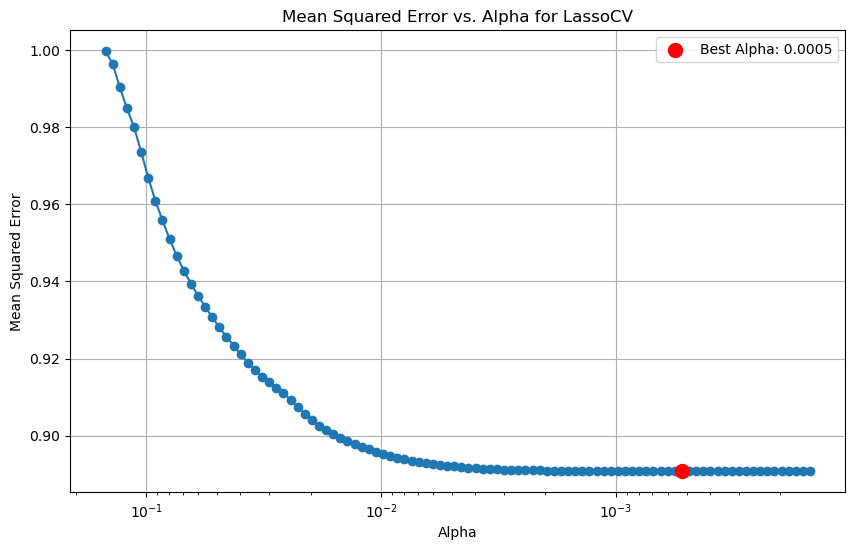

In [538]:
# Plot the CV alpha vs. MSE 
plt.figure(figsize=(10, 6))
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Alpha for LassoCV')
plt.xscale('log')  # Logarithmic scale for alpha
plt.gca().invert_xaxis()  # Optional: invert x-axis for better visualization
plt.grid(True)

# Highlight the point with the best alpha
optimal_alpha = lasso_cv.alpha_
optimal_mse = np.mean(lasso_cv.mse_path_, axis=1)[np.where(lasso_cv.alphas_ == optimal_alpha)][0]
plt.scatter(optimal_alpha, optimal_mse, color='red', s=100, zorder=5, label=f'Best Alpha: {optimal_alpha:.4f}')

# Add a legend and grid
plt.legend()
plt.grid(True)
plt.show()


### Decision Trees - Siboney

Root Mean Squared Error:  1491.54
Normalized Root Mean Squared Error: 27.33%, with a range of  5458.00.
Coefficient of Variation of Root Mean Squared Error: 88.99%, with a mean of  1676.05.


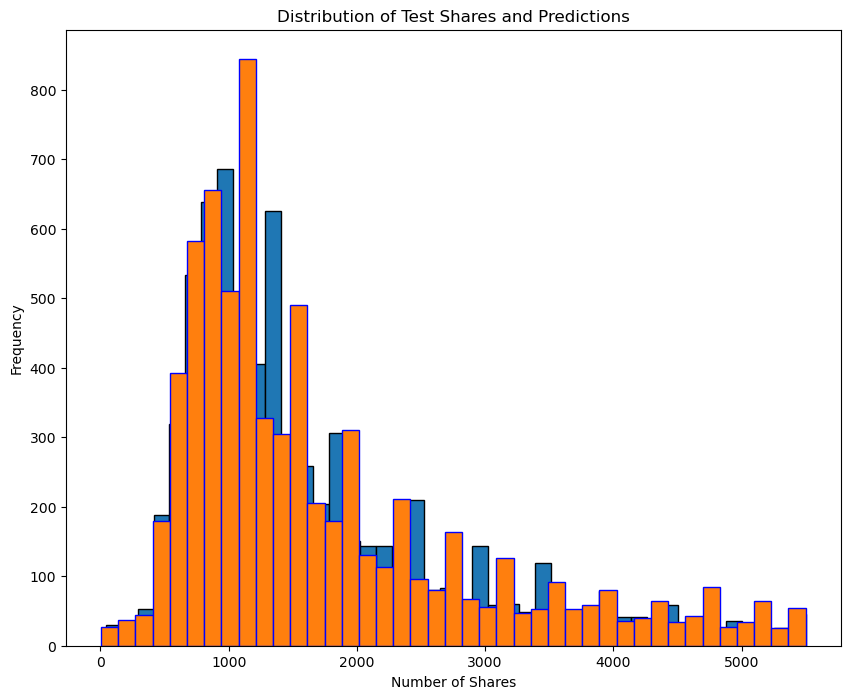

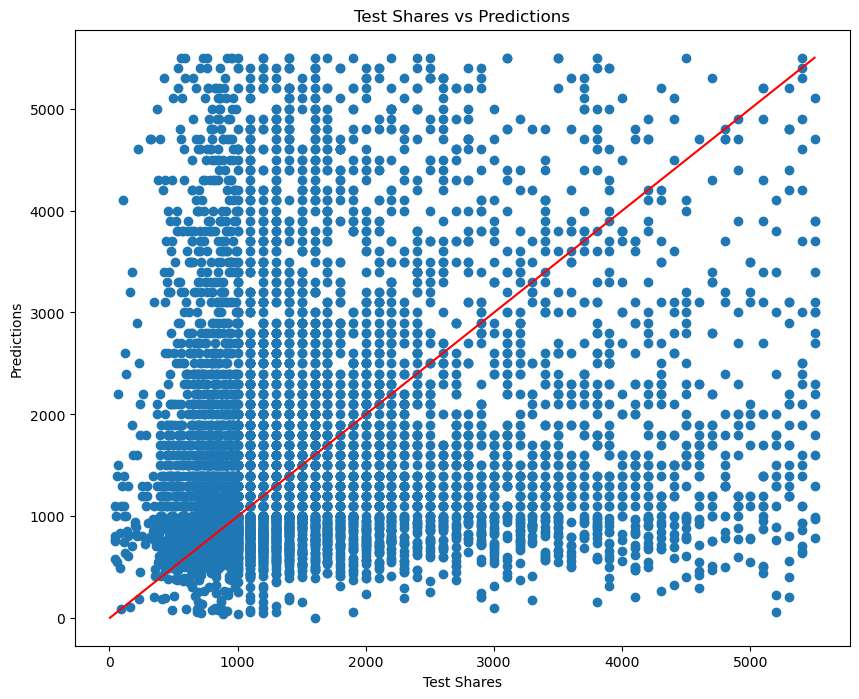

In [539]:
modeltrees = DecisionTreeRegressor(random_state=20)
modeltrees.fit(X_train, y_train)
y_predtrees = modeltrees.predict(X_test)

mean_sharestrees = mean_values['shares'].values[0]
std_sharestrees = std_values['shares'].values[0]

# Inverse transforming the predictions and true values
ypredtrees = y_predtrees * std_sharestrees + mean_sharestrees
ytesttrees = y_test * std_sharestrees + mean_sharestrees
RMSEtrees = np.sqrt(mean_squared_error(ytesttrees, ypredtrees))
NRMSEtrees = RMSEtrees * 100 / (np.max(ytesttrees) - np.min(ytesttrees))
CVRMSEtrees = RMSEtrees * 100 / np.mean(ytesttrees)


print(f'Root Mean Squared Error: {RMSEtrees: .2f}')
print(f"Normalized Root Mean Squared Error: {NRMSEtrees:.2f}%, with a range of {np.max(ytesttrees) - np.min(ytesttrees): .2f}.")
print(f"Coefficient of Variation of Root Mean Squared Error: {CVRMSEtrees:.2f}%, with a mean of {np.mean(ytesttrees): .2f}.")

plt.figure(figsize = (10,8))
plt.hist(ytesttrees, bins='auto', edgecolor='black')
plt.hist(ypredtrees, bins='auto', edgecolor = 'blue')
plt.title("Distribution of Test Shares and Predictions")
plt.xlabel("Number of Shares")
plt.ylabel("Frequency")
plt.show()

min_val = min(min(ytesttrees), min(ypredtrees))
max_val = max(max(ytesttrees), max(ypredtrees))

plt.figure(figsize = (10, 8))
plt.scatter(ytesttrees, ypredtrees)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='red')
plt.title("Test Shares vs Predictions")
plt.xlabel("Test Shares")
plt.ylabel("Predictions")
plt.show()


Root Mean Squared Error:  1035.02
Normalized Root Mean Squared Error: 18.96%, with a range of  5458.00.
Coefficient of Variation of Root Mean Squared Error: 61.75%, with a mean of  1676.05.


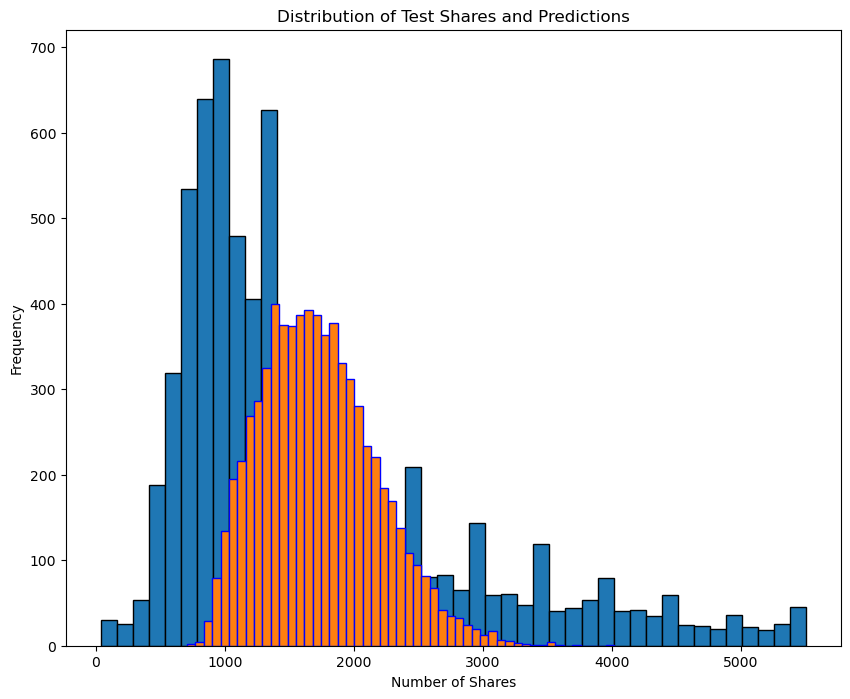

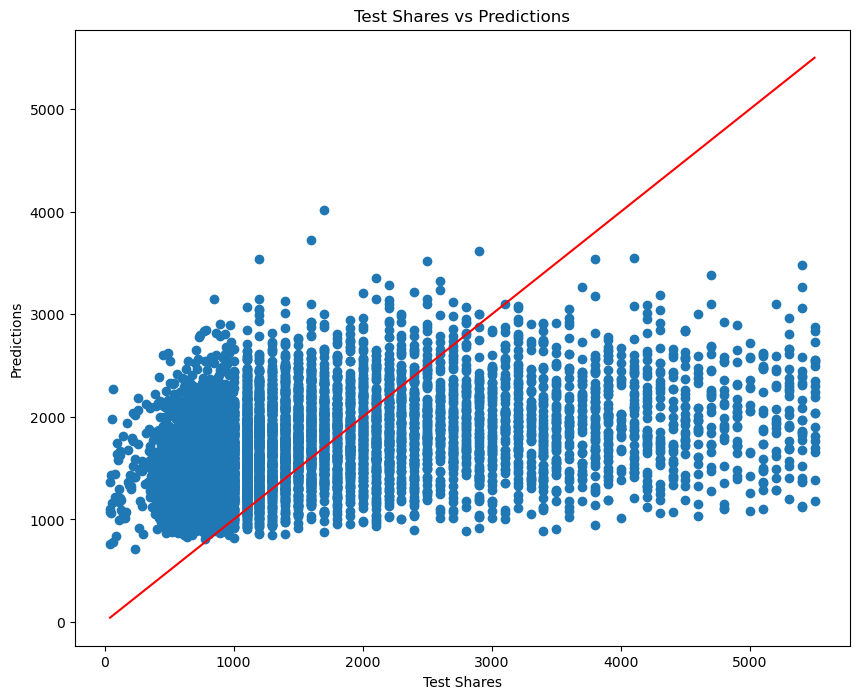

In [540]:
#random forest

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_model.predict(X_test)
# Calculate Mean Squared Error
# Inverse transforming the predictions and true values
ypredtrees = y_pred * std_sharestrees + mean_sharestrees
RMSEtreesrf = np.sqrt(mean_squared_error(ytesttrees, ypredtrees))
NRMSEtreesrf = RMSEtreesrf * 100 / (np.max(ytesttrees) - np.min(ytesttrees))
CVRMSEtreesrf = RMSEtreesrf * 100 / np.mean(ytesttrees)


print(f'Root Mean Squared Error: {RMSEtreesrf: .2f}')
print(f"Normalized Root Mean Squared Error: {NRMSEtreesrf:.2f}%, with a range of {np.max(ytesttrees) - np.min(ytesttrees): .2f}.")
print(f"Coefficient of Variation of Root Mean Squared Error: {CVRMSEtreesrf:.2f}%, with a mean of {np.mean(ytesttrees): .2f}.")

plt.figure(figsize = (10,8))
plt.hist(ytesttrees, bins='auto', edgecolor='black')
plt.hist(ypredtrees, bins='auto', edgecolor = 'blue')
plt.title("Distribution of Test Shares and Predictions")
plt.xlabel("Number of Shares")
plt.ylabel("Frequency")
plt.show()

min_val = min(min(ytesttrees), min(ypredtrees))
max_val = max(max(ytesttrees), max(ypredtrees))

plt.figure(figsize = (10, 8))
plt.scatter(ytesttrees, ypredtrees)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='red')
plt.title("Test Shares vs Predictions")
plt.xlabel("Test Shares")
plt.ylabel("Predictions")
plt.show()

### Neural Nets - Ramzi

In [541]:
## Converting Dataframes to PyTorch Tensors

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) 
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1) 

In [542]:
# Create Dataset objects 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Batch sizes of 32 are a standard size
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

In [543]:
## Constructing a PyTorch Model
class SimpleNN(nn.Module):
    def __init__(self, input_features):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_features, 128)
        self.layer2 = nn.Tanh()
        self.layer3 = nn.Linear(128, 256)
        self.layer4 = nn.Tanh()
        self.layer5 = nn.Linear(256, 512)
        self.layer6 = nn.Tanh()
        self.layer7 = nn.Linear(512, 512)
        self.layer8 = nn.Tanh()
        self.layer9 = nn.Linear(512, 128)
        self.layer10 = nn.Tanh()
        self.layer11 = nn.Linear(128, 64)
        self.layer12 = nn.ReLU()
        self.layer13 = nn.Linear(64, 1)
        
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)

        
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        return x

inputshape = X_train_tensor.shape[1]
model = SimpleNN(inputshape)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [544]:
## Training 

patience = 5 # Number of epochs before early stoppage is assessed 
best_val_loss = float('inf') 
epochs_no_improve = 0

for epoch in range(10):
    model.train()
    for data, target in train_loader: 
        optimizer.zero_grad()
        predictions = model(data)
        loss = criterion(predictions, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}') #, Validation Loss: {val_loss}')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


Root Mean Squared Error: 1026.28
Normalized Root Mean Squared Error: 18.80%
Coefficient of Variation of Root Mean Squared Error: 61.23%


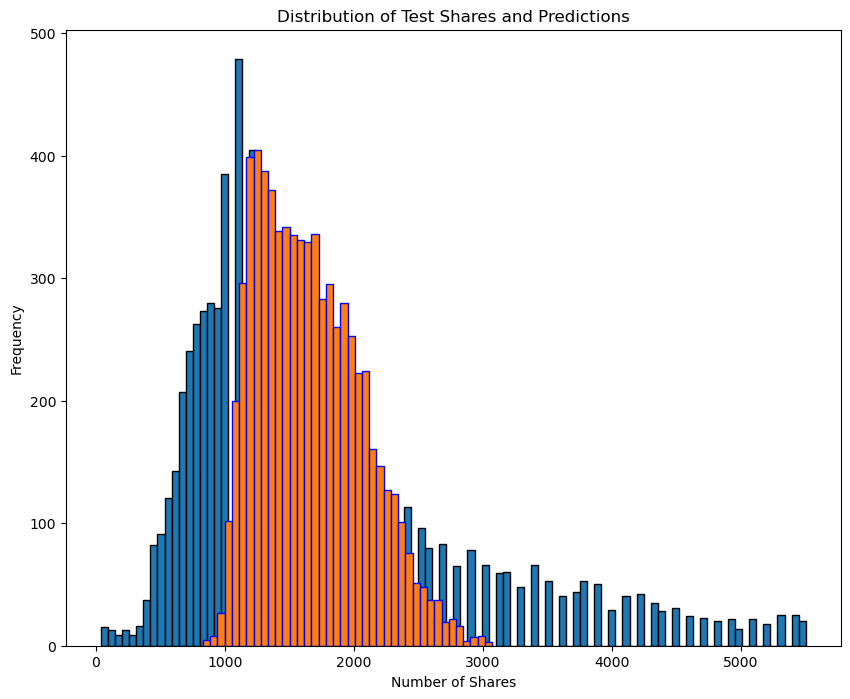

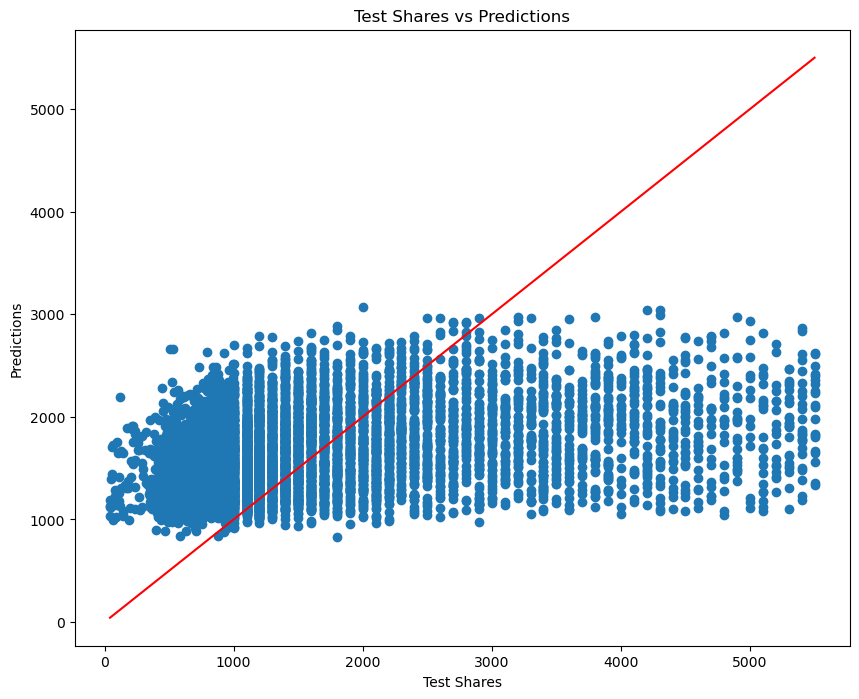

In [547]:
## OOS MSE

# Calculate the out-of-sample MSE
all_predictions = []

model.eval()

with torch.no_grad():
    for data, target in test_loader:

        batch_predictions = model(data)

        all_predictions.append(batch_predictions)


all_predictions = torch.cat(all_predictions, dim=0).numpy()

mean_shares = mean_values['shares'].values[0]

std_shares = std_values['shares'].values[0]

predictions = (all_predictions * std_shares) + mean_shares

ytest = (y_test_tensor.numpy() * std_shares) + mean_shares

RMSE = np.sqrt(np.mean((predictions - ytest) ** 2))
NRMSE = RMSE * 100 / (np.max(ytest) - np.min(ytest))
CVRMSE = RMSE * 100 / np.mean(ytest)

print(f"Root Mean Squared Error: {RMSE:.2f}")
print(f"Normalized Root Mean Squared Error: {NRMSE:.2f}%")
print(f"Coefficient of Variation of Root Mean Squared Error: {CVRMSE:.2f}%")


plt.figure(figsize = (10,8))
plt.hist(ytest, bins=100, edgecolor='black')
plt.hist(predictions, bins=40, edgecolor = 'blue')
plt.title("Distribution of Test Shares and Predictions")
plt.xlabel("Number of Shares")
plt.ylabel("Frequency")
plt.show()

min_val = min(min(ytest), min(predictions))
max_val = max(max(ytest), max(predictions))

plt.figure(figsize = (10, 8))
plt.scatter(ytest, predictions)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='red')
plt.title("Test Shares vs Predictions")
plt.xlabel("Test Shares")
plt.ylabel("Predictions")
plt.show()


### Regression Model Evaluations

In [515]:
## Model Evaluations
RMSEs = [RMSEknn, ols_rmse, lasso_rmse, RMSEtrees, RMSEtreesrf, RMSE]
NRMSEs = [NRMSEknn, ols_nrmse, lasso_nrmse, NRMSEtrees, NRMSEtreesrf, NRMSE]
CVRMSEs = [CVRMSE, ols_cvrmse, lasso_cvrmse, CVRMSEtrees, CVRMSEtreesrf, CVRMSE]
Columns = ['KNN', 'Ordinary Least Squares', 'Lasso Linear Regression', 'Decision Tree Classifier', 'Random Forest', 'Neural Network']

results = pd.DataFrame({
    'Model': Columns,
    'RMSE': RMSEs,
    'NRMSE': NRMSEs,
    'CVRMSE': CVRMSEs
})

results

,Model,RMSE,NRMSE,CVRMSE
0,KNN,1084.203492,19.864483,61.296118
1,Ordinary Least Squares,1044.410331,19.135404,62.313746
2,Lasso Linear Regression,1044.655823,19.139901,62.328393
3,Decision Tree Classifier,1491.535674,27.327513,88.991053
4,Random Forest,1035.024315,18.963436,61.753738
5,Neural Network,1027.354370,18.822909,61.296118


### Naive Bayes Theorem - Andrew

In [358]:
# Naive Bayes requires bins or categorical target variables - I am opting for converting our continuous target into 5 bins.
num_bins = 5
y_train_binned = pd.cut(y_train, bins=num_bins, labels=False)
y_test_binned = pd.cut(y_test, bins=num_bins, labels=False)

In [359]:
# Setting the model as Gaussian NB; necessary for numerical continuous data
model = GaussianNB()

In [360]:
# Fitting and Testing the Model
model.fit(X_train, y_train_binned)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_binned, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.4294260076912121


In [361]:
# K-fold cross-validation (using 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train_binned, cv=kf, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Cross-Validation Accuracy Scores: [0.42887662 0.42139932 0.43945869 0.41880342 0.41452991]
Mean CV Accuracy: 0.42461359416139544


In [363]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

# Use StratifiedKFold with the desired number of splits
stratified_kf = StratifiedKFold(n_splits=3)  # Adjust n_splits based on your data

calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=stratified_kf)
calibrated_model.fit(X_train, y_train_binned)

# Evaluate the calibrated model
y_pred_calibrated = calibrated_model.predict(X_test)
calibrated_accuracy = accuracy_score(y_test_binned, y_pred_calibrated)
print(f'Calibrated Model Accuracy: {calibrated_accuracy}')

Calibrated Model Accuracy: 0.47756729810568294


In [364]:
# Fit the model first
model.fit(X_train, y_train_binned)

# Compute permutation feature importance
result = permutation_importance(model, X_test, y_test_binned, n_repeats=10, random_state=42)

# Print the feature importance
for i in result.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

data_channel_is_socmed: 0.016 +/- 0.002
weekday_is_saturday: 0.007 +/- 0.002
is_weekend: 0.006 +/- 0.002
weekday_is_sunday: 0.006 +/- 0.002
kw_avg_avg: 0.005 +/- 0.001
data_channel_is_tech: 0.005 +/- 0.002
LDA_04: 0.004 +/- 0.002
data_channel_is_lifestyle: 0.003 +/- 0.001
num_hrefs: 0.003 +/- 0.001
kw_min_avg: 0.003 +/- 0.001
kw_max_avg: 0.002 +/- 0.001
num_keywords: 0.002 +/- 0.001
self_reference_max_shares: 0.002 +/- 0.001
weekday_is_wednesday: 0.002 +/- 0.001
kw_min_max: 0.002 +/- 0.001
n_tokens_content: 0.002 +/- 0.001
self_reference_min_shares: 0.002 +/- 0.001
num_self_hrefs: 0.001 +/- 0.001
data_channel_is_entertainment: 0.001 +/- 0.001
weekday_is_friday: 0.001 +/- 0.001
self_reference_avg_sharess: 0.001 +/- 0.001
title_subjectivity: 0.001 +/- 0.000
num_imgs: 0.001 +/- 0.001
abs_title_sentiment_polarity: 0.001 +/- 0.001
num_videos: 0.001 +/- 0.001
min_negative_polarity: 0.001 +/- 0.001
data_channel_is_bus: 0.001 +/- 0.001
weekday_is_tuesday: 0.001 +/- 0.001
global_sentiment_polar

In [ ]:
# The variables that introduced the least amount of error were weekends, Sundays, and lifestyle (?)